# Principal Component Analysis(PCA)
@Yu-Wei Hsu

Dataset description:

The data was taken over a 2-month period in India with 25 features. The target is the classification, which is either 'ckd' or 'notckd' - ckd = chronic kidney disease. We would like to use PCA to reduce dimensionailty of dataset. 
The discription of dataset are from https://www.kaggle.com/colearninglounge/chronic-kidney-disease?select=kidney_disease_test.csv. We would like to use these descriptions for interpretation purpose.

Column description:

Numerical variable:
- age: Age in years
- bp: Blood Pressure in mm/Hg
- bgr: Blood Glucose Random in mgs/dl
- bu: Blood Urea in mgs/dl
- sc: Serum Creatinine in mgs/dl
- sod: Sodium in mEq/L
- pot: Potassium in mEq/L
- hemo: Hemoglobin in gms
- pcv: Packed Cell Volume
- wc: White Blood Cell Count in cells/cumm
- rc: Red Blood Cell Count in millions/cmm

Nomial variable:
- sg: Specific Gravity
- al: Albumin
- su: Sugar
- rbc: Red Blood Cells
- pc: Pus Cell
- pcc: Pus Cell clumps
- ba: Bacteria
- htn: Hypertension
- dm: Diabetes Mellitus
- cad: Coronary Artery Disease
- appet: Appetite
- pe: Pedal Edema
- ane: Anemia
- classification: Chronic Kidney Disease, not Chronic Kidney Disease


###Set up environment

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
# Set the graph size
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,6)

Acquire data

In [ ]:
# Acquire dataset
df = pd.read_csv('kidney_disease_train.csv')
print('Shape of dataset: ',df.shape)

Shape of dataset:  (280, 26)


###EDA

In [ ]:
df.head(3)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,157,62.0,70.0,1.025,3.0,0.0,normal,abnormal,notpresent,notpresent,122.0,42.0,1.7,136.0,4.7,12.6,39.0,7900,3.9,yes,yes,no,good,no,no,ckd
1,109,54.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,233.0,50.1,1.9,NaN,NaN,11.7,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
2,17,47.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,114.0,87.0,5.2,139.0,3.7,12.1,NaN,NaN,NaN,yes,no,no,poor,no,no,ckd


In [ ]:
df.tail(3)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
277,270,23.0,80.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,111.0,34.0,1.1,145.0,4.0,14.3,41.0,7200,5.0,no,no,no,good,no,no,notckd
278,348,38.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,99.0,19.0,0.5,147.0,3.5,13.6,44.0,7300,6.4,no,no,no,good,no,no,notckd
279,102,17.0,60.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,92.0,32.0,2.1,141.0,4.2,13.9,52.0,7000,NaN,no,no,no,good,no,no,ckd


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              280 non-null    int64  
 1   age             275 non-null    float64
 2   bp              271 non-null    float64
 3   sg              244 non-null    float64
 4   al              245 non-null    float64
 5   su              242 non-null    float64
 6   rbc             173 non-null    object 
 7   pc              230 non-null    object 
 8   pcc             276 non-null    object 
 9   ba              276 non-null    object 
 10  bgr             247 non-null    float64
 11  bu              266 non-null    float64
 12  sc              268 non-null    float64
 13  sod             213 non-null    float64
 14  pot             212 non-null    float64
 15  hemo            241 non-null    float64
 16  pcv             229 non-null    float64
 17  wc              203 non-null    obj

- There are missing values in few columns, and we can drop the id column before we start the exploratory data anaylsis. 

In [ ]:
# Drop id column
df.drop(columns=['id'],inplace=True)

# Check missing values in each column
na_df  = pd.DataFrame(columns=['feature','number_of_NaN','pct_of_NaN'])
na_df['feature'] = df.columns
na_df['number_of_NaN'] = list(df.isnull().sum())
na_df['pct_of_NaN'] = [round(i/len(df),3) for i in na_df['number_of_NaN']]
na_df.sort_values(by='pct_of_NaN',ascending=False)

,feature,number_of_NaN,pct_of_NaN
5,rbc,107,0.382
17,rc,93,0.332
16,wc,77,0.275
13,pot,68,0.243
12,sod,67,0.239
15,pcv,51,0.182
6,pc,50,0.179
14,hemo,39,0.139
4,su,38,0.136
2,sg,36,0.129


- Since the pertange of missing values in few colums are above 20%, which is not a small proportion to ignore, we can evaluate and fill the median value for numerical varialbes and mode for categorical variables.

In [ ]:
# Check each feature value
for col in list(df.columns):
    print(df[col].value_counts())
    print()

65.0    14
60.0    13
56.0     9
50.0     9
54.0     8
        ..
4.0      1
49.0     1
81.0     1
26.0     1
21.0     1
Name: age, Length: 70, dtype: int64

80.0     81
70.0     81
60.0     52
90.0     32
100.0    16
50.0      4
110.0     2
180.0     1
140.0     1
120.0     1
Name: bp, dtype: int64

1.020    74
1.010    61
1.025    57
1.015    48
1.005     4
Name: sg, dtype: int64

0.0    139
1.0     29
2.0     29
3.0     29
4.0     18
5.0      1
Name: al, dtype: int64

0.0    199
1.0     12
2.0     11
3.0     10
4.0      8
5.0      2
Name: su, dtype: int64

normal      144
abnormal     29
Name: rbc, dtype: int64

normal      181
abnormal     49
Name: pc, dtype: int64

notpresent    250
present        26
Name: pcc, dtype: int64

notpresent    260
present        16
Name: ba, dtype: int64

99.0     8
92.0     6
100.0    6
125.0    5
130.0    5
        ..
264.0    1
204.0    1
224.0    1
146.0    1
156.0    1
Name: bgr, Length: 126, dtype: int64

46.0     11
19.0      8
40.0      8
28.0 

- There are '\t' in wc, rc, dm, and cad columns, which we should remove before we fill na value. 

Data Cleaning

In [ ]:
# Fix the values
tab_col = ['wc','rc','dm','cad']

# Check the orignal unique value in the columns
for col in tab_col:
  print(df[col].unique())

['7900' nan '7200' '8300' '4200' '9900' '10500' '2200' '7500' '8400'
 '15700' '7000' '4700' '9600' '6700' '9000' '5900' '4300' '12700' '5500'
 '5000' '9700' '6900' '9800' '5800' '6400' '8100' '15200' '5600' '14900'
 '9100' '26400' '8000' '6500' '9200' '6800' '10800' '4500' '\t?' '10700'
 '11000' '9400' '6300' '10300' '9500' '6200' '6600' '4100' '7700' '5400'
 '13600' '\t8400' '11500' '10900' '12200' '8600' '7300' '5200' '7400'
 '12800' '6000' '9300' '7800' '10400' '8800' '10200' '16700' '8500'
 '21600' '12500' '13200' '5100' '12300' '18900' '5700' '8200' '16300'
 '4900' '14600']
['3.9' nan '5.5' '4.6' '3.4' '4.7' '6.1' '2.6' '5.6' '3.3' '3.8' '5.0'
 '4.5' '5.7' '3.5' '6.0' '5.2' '4.2' '3.7' '5.9' '4.9' '4.8' '3.2' '3.0'
 '3.6' '4.0' '2.5' '4.1' '6.2' '5.1' '6.5' '5.8' '4.4' '5.4' '3' '4.3' '4'
 '2.1' '8.0' '5.3' '3.1' '2.3' '\t?' '2.9' '6.3' '6.4' '2.4' '2.7' '5']
['yes' 'no' '\tyes' '\tno' nan]
['no' 'yes' nan '\tno']


In [ ]:
# Correct the values
df['wc'] = df['wc'].replace({'\t?':np.nan,'\t8400':8400})
df['rc'] = df['rc'].replace({'\t?':np.nan})
df['dm'] = df['dm'].replace({'\tyes':'yes','\tno':'no'})
df['cad'] = df['cad'].replace({'\tno':'no'})

# Check the unique value after replace
for col in tab_col:
  print(df[col].unique())

['7900' nan '7200' '8300' '4200' '9900' '10500' '2200' '7500' '8400'
 '15700' '7000' '4700' '9600' '6700' '9000' '5900' '4300' '12700' '5500'
 '5000' '9700' '6900' '9800' '5800' '6400' '8100' '15200' '5600' '14900'
 '9100' '26400' '8000' '6500' '9200' '6800' '10800' '4500' '10700' '11000'
 '9400' '6300' '10300' '9500' '6200' '6600' '4100' '7700' '5400' '13600'
 8400 '11500' '10900' '12200' '8600' '7300' '5200' '7400' '12800' '6000'
 '9300' '7800' '10400' '8800' '10200' '16700' '8500' '21600' '12500'
 '13200' '5100' '12300' '18900' '5700' '8200' '16300' '4900' '14600']
['3.9' nan '5.5' '4.6' '3.4' '4.7' '6.1' '2.6' '5.6' '3.3' '3.8' '5.0'
 '4.5' '5.7' '3.5' '6.0' '5.2' '4.2' '3.7' '5.9' '4.9' '4.8' '3.2' '3.0'
 '3.6' '4.0' '2.5' '4.1' '6.2' '5.1' '6.5' '5.8' '4.4' '5.4' '3' '4.3' '4'
 '2.1' '8.0' '5.3' '3.1' '2.3' '2.9' '6.3' '6.4' '2.4' '2.7' '5']
['yes' 'no' nan]
['no' 'yes' nan]


In [ ]:
# Slice numerical and categorical variable
df_col = df.columns
num_col = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
cat_col = [c for c in df_col if c not in num_col]
cat_col.remove('classification')

In [ ]:
# Check the unique value in categorical variables
for col in cat_col:
  print('{}: {}\n'.format(col,df[col].unique()))

sg: [1.025   nan 1.015 1.01  1.02  1.005]

al: [ 3. nan  0.  4.  5.  2.  1.]

su: [ 0. nan  1.  3.  2.  4.  5.]

rbc: ['normal' nan 'abnormal']

pc: ['abnormal' nan 'normal']

pcc: ['notpresent' 'present' nan]

ba: ['notpresent' 'present' nan]

htn: ['yes' 'no' nan]

dm: ['yes' 'no' nan]

cad: ['no' 'yes' nan]

appet: ['good' 'poor']

pe: ['no' 'yes']

ane: ['no' 'yes']



In [ ]:
# Encode nominal variable manually
cat_dict = {'rbc':{'normal':1, 'abnormal':0}, 'pc':{'normal':1, 'abnormal':0},
            'pcc':{'present':1, 'notpresent':0}, 'ba':{'present':1, 'notpresent':0},
            'htn':{'yes':1, 'no':0}, 'dm':{'yes':1, 'no':0}, 'cad':{'yes':1, 'no':0},
            'appet':{'good':1, 'poor':0}, 'pe':{'yes':1, 'no':0}, 
            'ane':{'yes':1, 'no':0}, 'classification':{'ckd':1, 'notckd':0}}
df.replace(cat_dict,inplace=True)

In [ ]:
# Fill na for both numerical and categorical varibles
for col in num_col:
  df[col].fillna(df[col].median(),inplace = True)

for col in cat_col:
  df[col].fillna(df[col].mode()[0],inplace = True)

# Check missing value and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             280 non-null    float64
 1   bp              280 non-null    float64
 2   sg              280 non-null    float64
 3   al              280 non-null    float64
 4   su              280 non-null    float64
 5   rbc             280 non-null    float64
 6   pc              280 non-null    float64
 7   pcc             280 non-null    float64
 8   ba              280 non-null    float64
 9   bgr             280 non-null    float64
 10  bu              280 non-null    float64
 11  sc              280 non-null    float64
 12  sod             280 non-null    float64
 13  pot             280 non-null    float64
 14  hemo            280 non-null    float64
 15  pcv             280 non-null    float64
 16  wc              280 non-null    object 
 17  rc              280 non-null    obj

In [ ]:
# Fix data type for wc and rc
df['wc'] = df['wc'].astype(float)
df['rc'] = df['rc'].astype(float)

Visualization

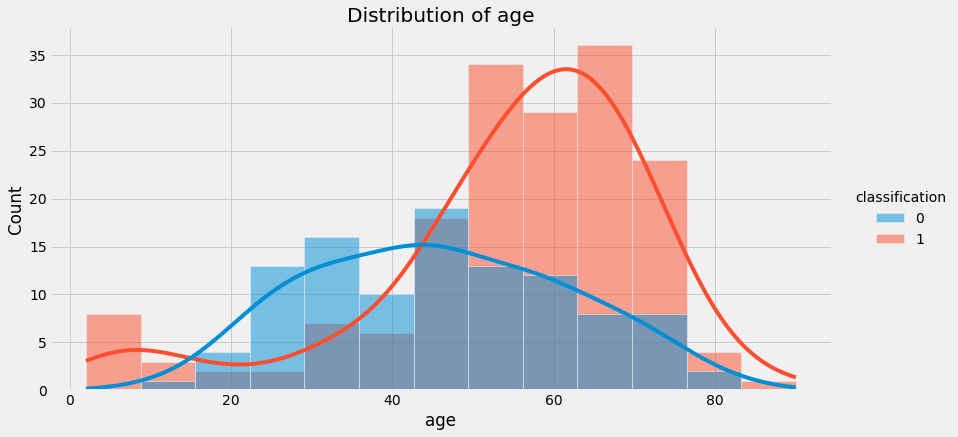

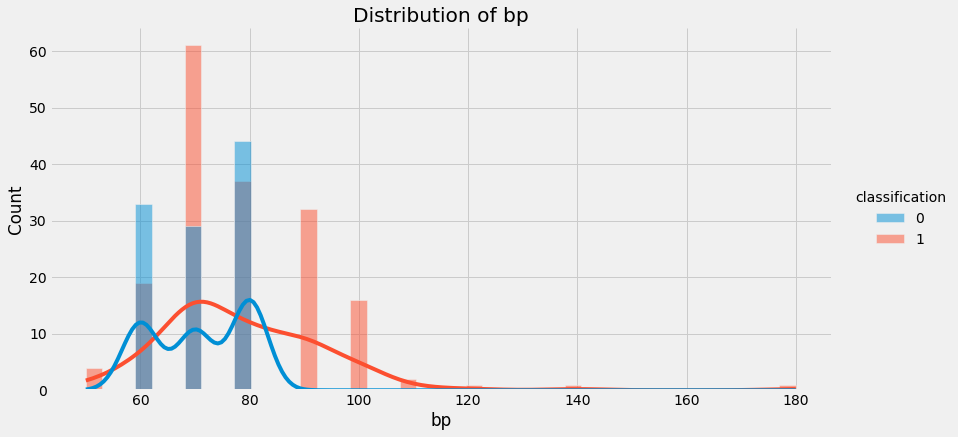

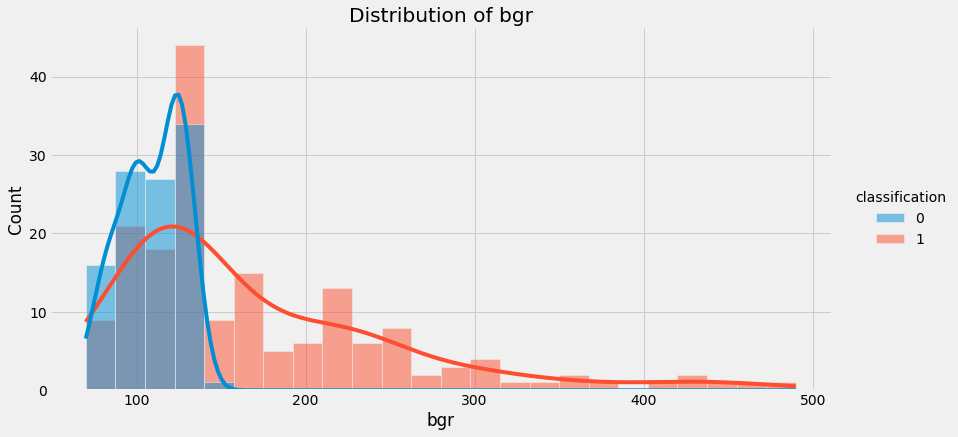

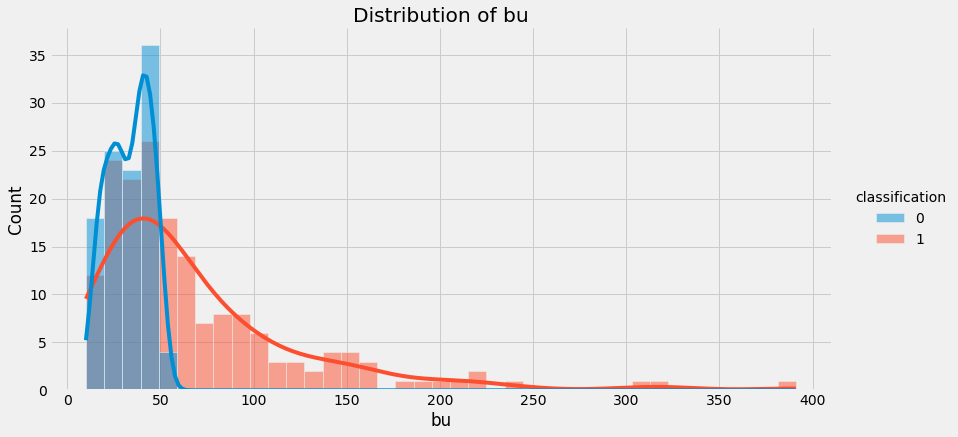

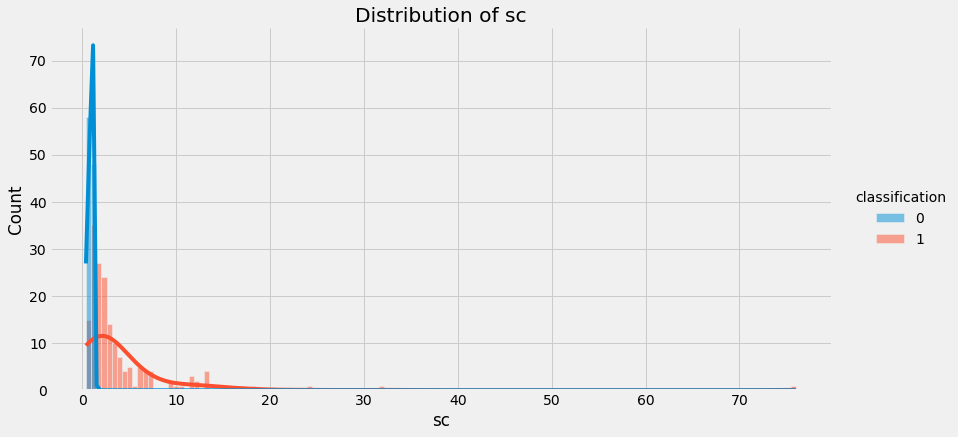

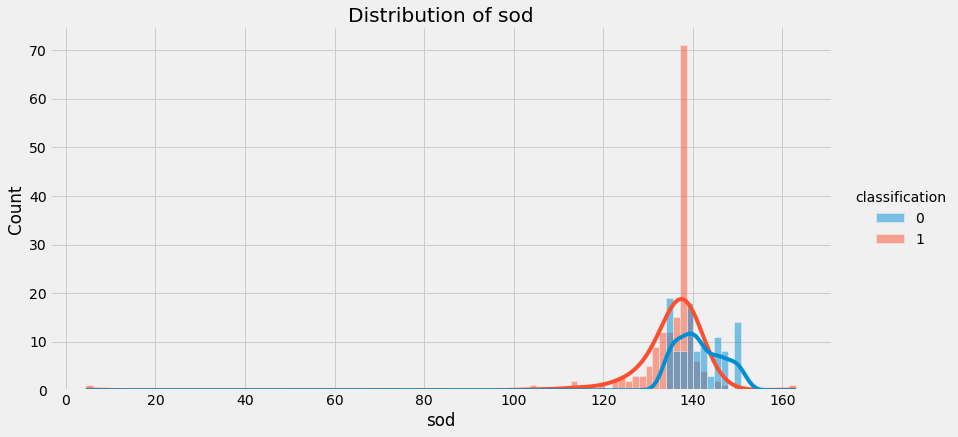

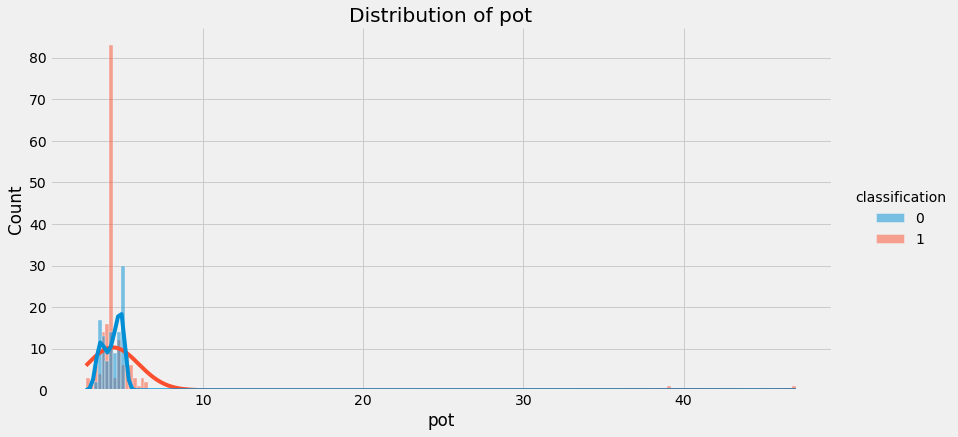

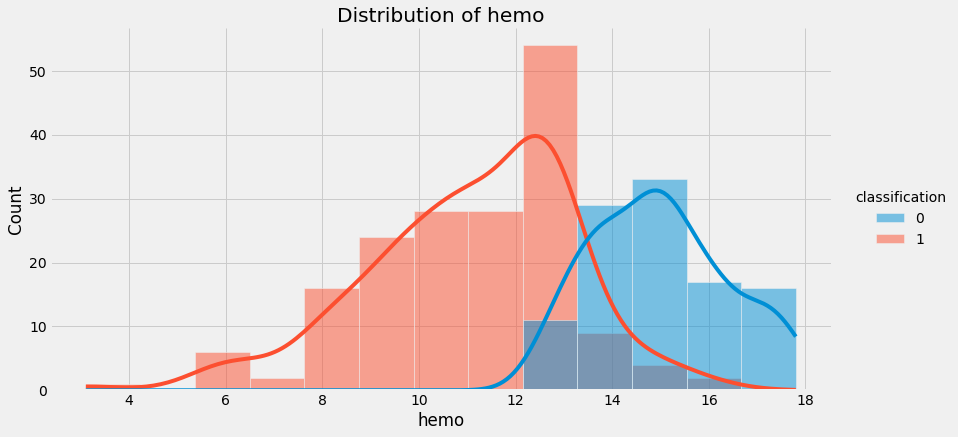

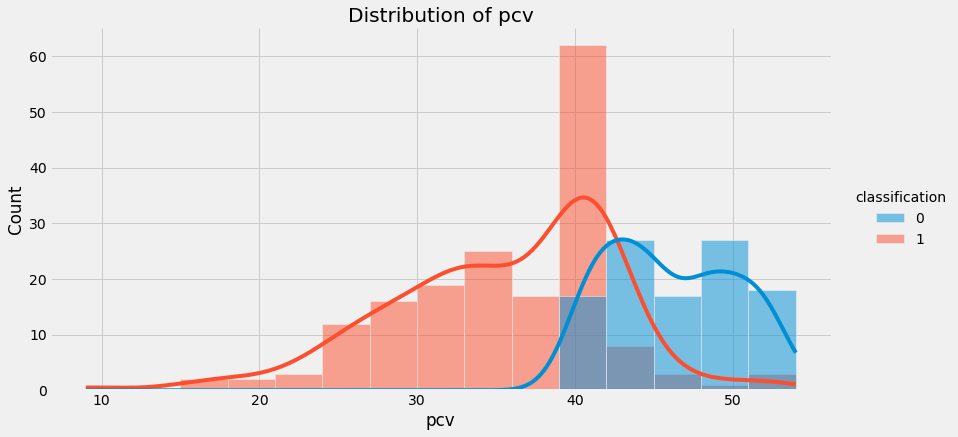

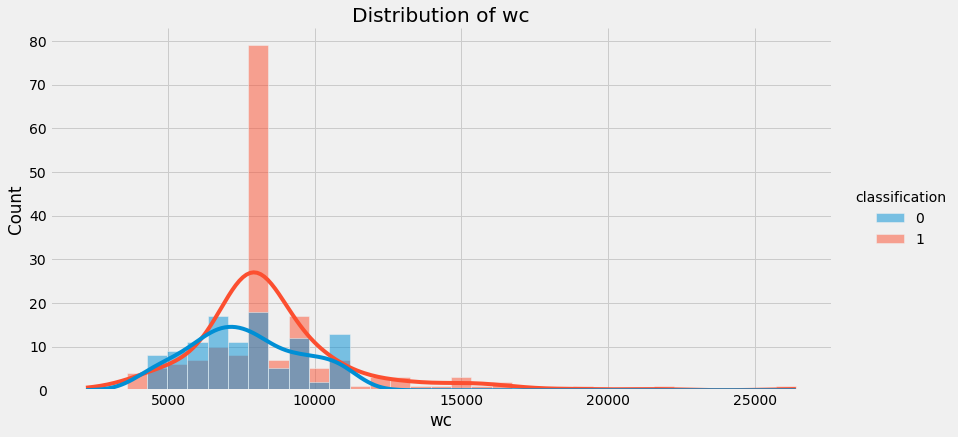

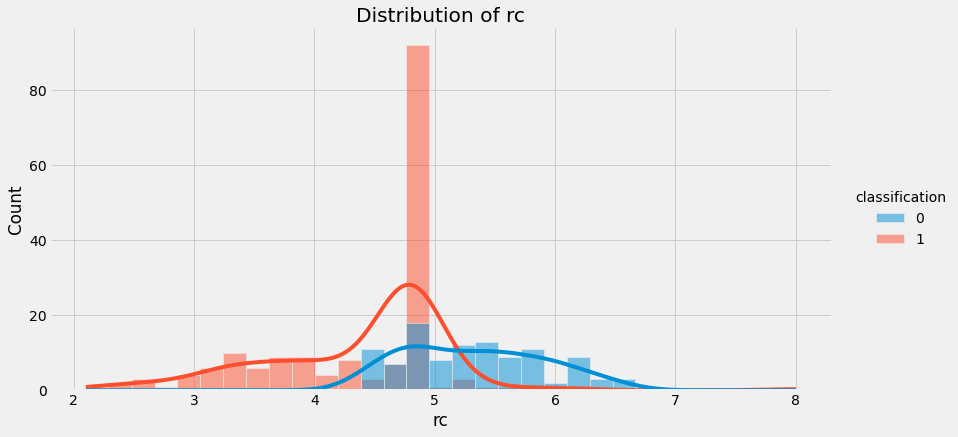

In [ ]:
# Plot the density plot and histogram for numerical features
for col in num_col:
  sns.displot(data= df, x = col, hue = 'classification',kde=True,height=6,aspect=2)
  title = 'Distribution of '+ str(col)
  plt.title(title)
  plt.show()

- We can find out there exista clearly difference between classification as CKD and non CDK in some features such as age, sc, hemo, pcv, and rc.
- Besides, there might be outliers in some attributes. For example, bu and sod spread wider than other features.

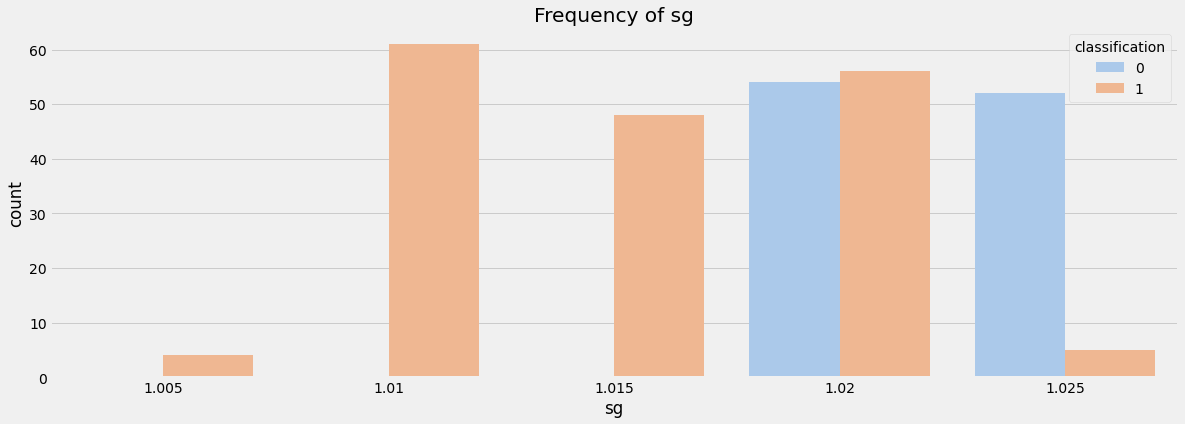

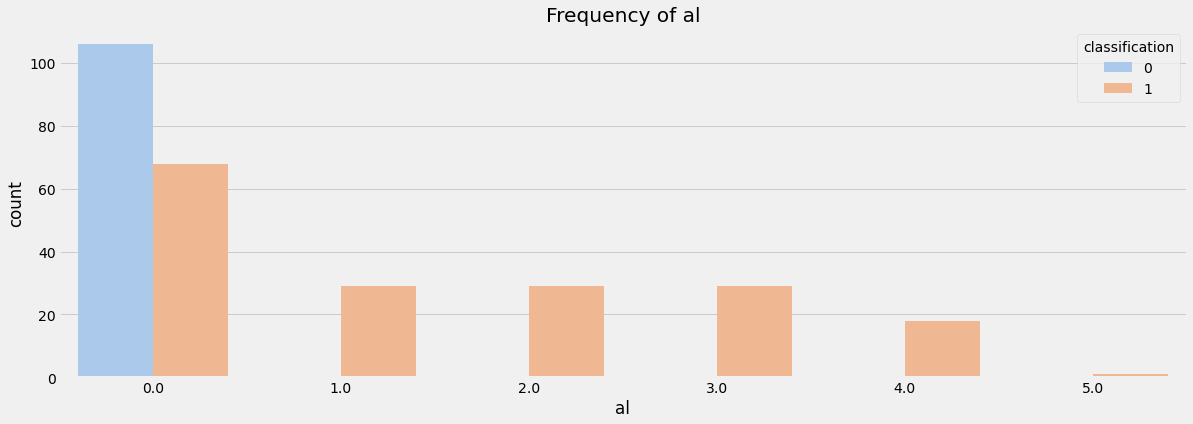

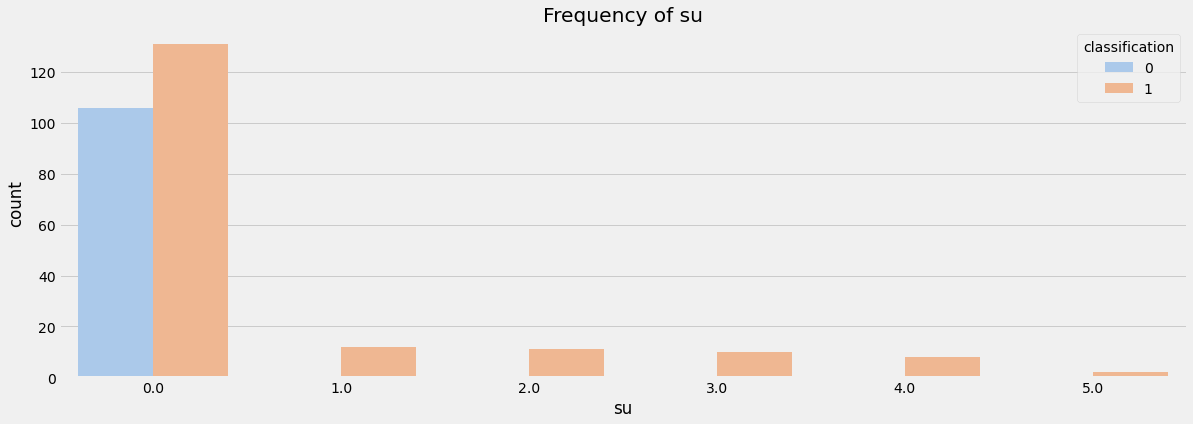

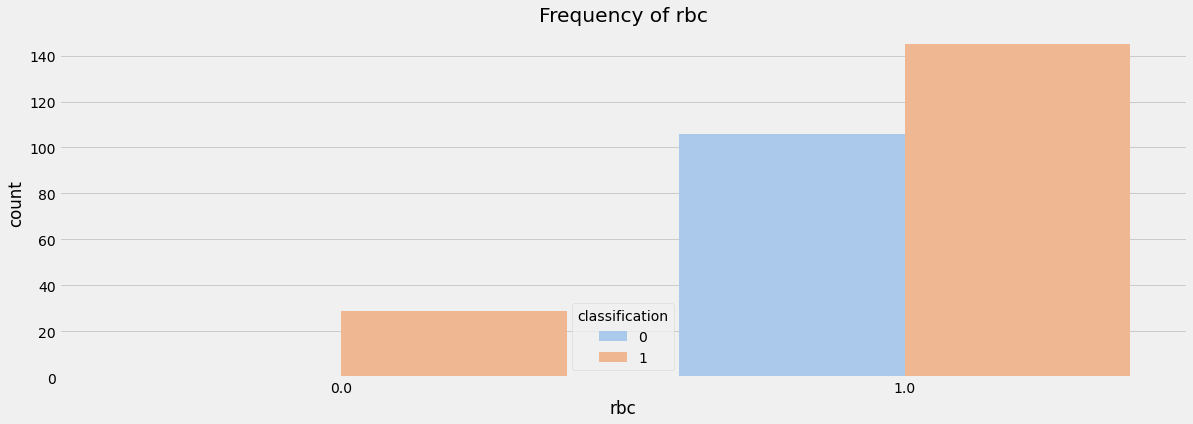

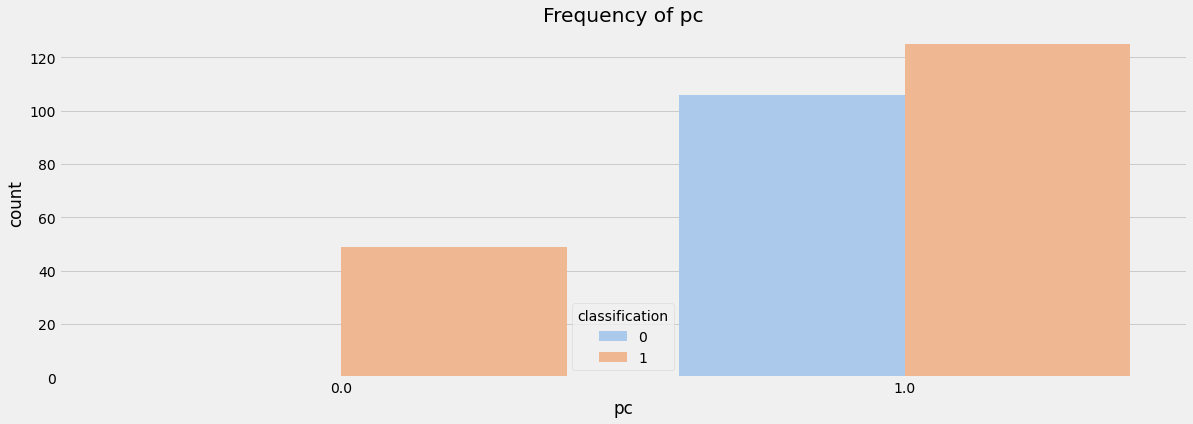

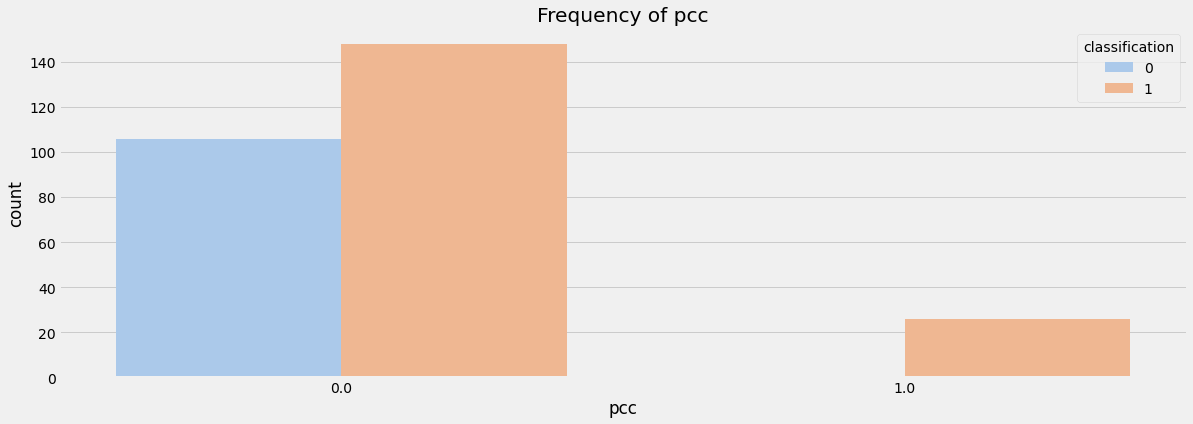

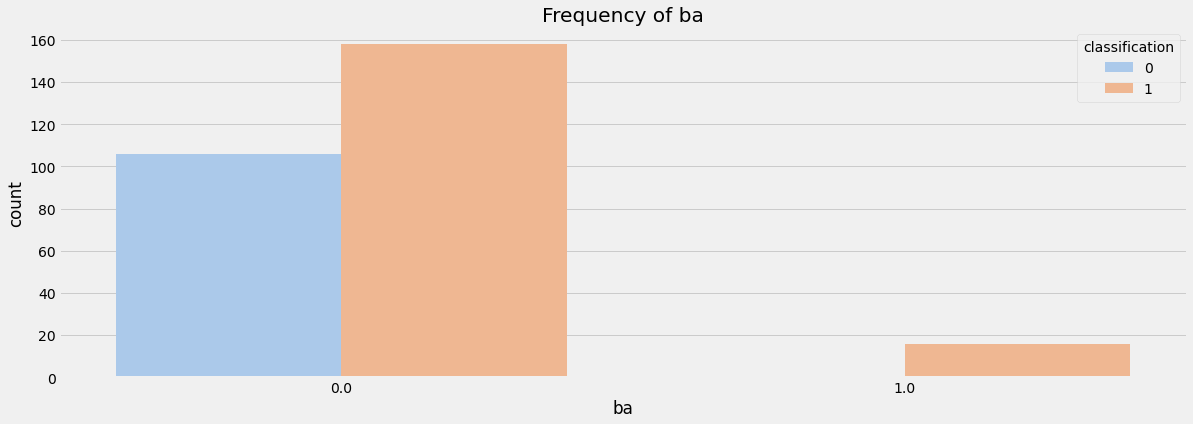

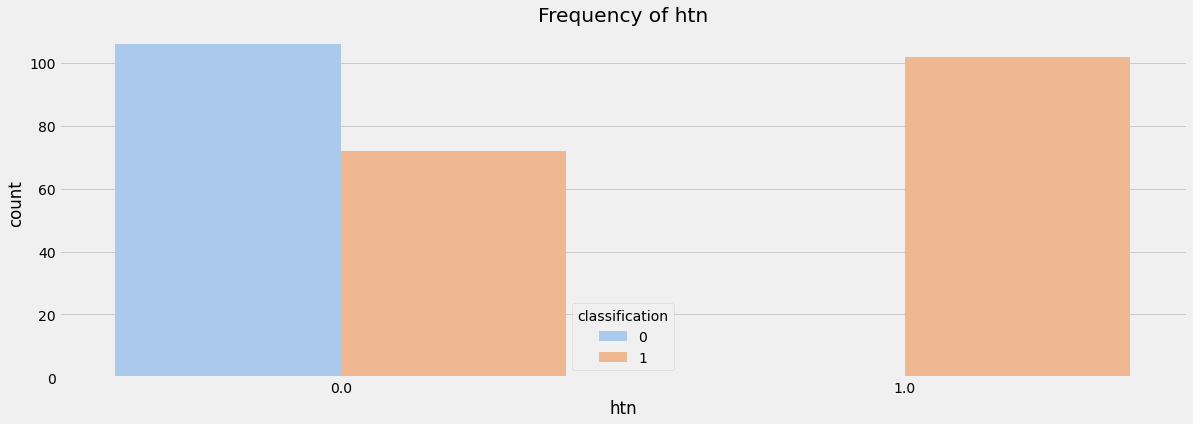

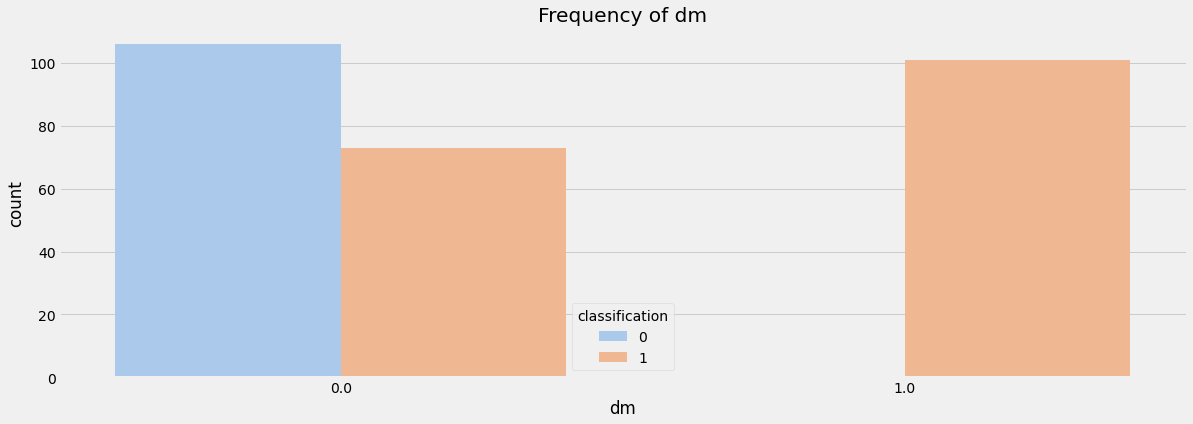

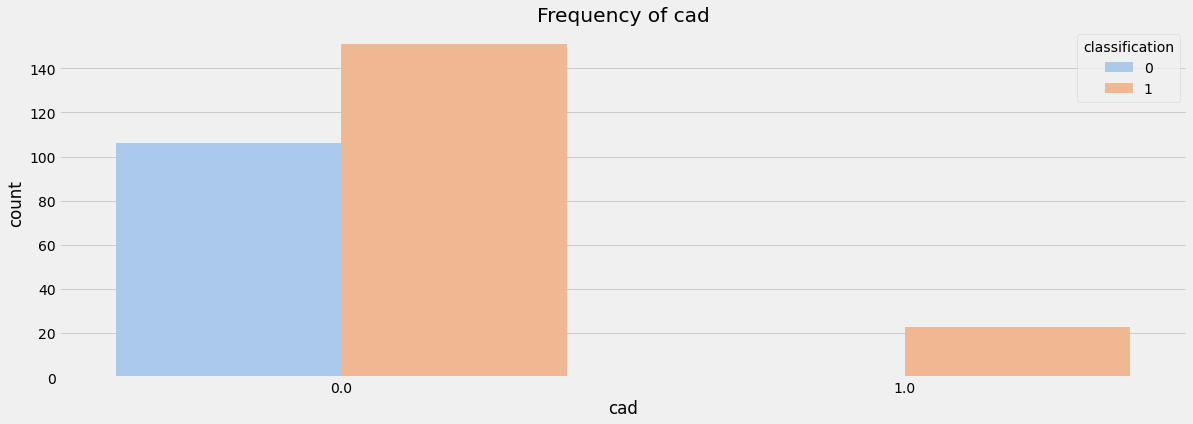

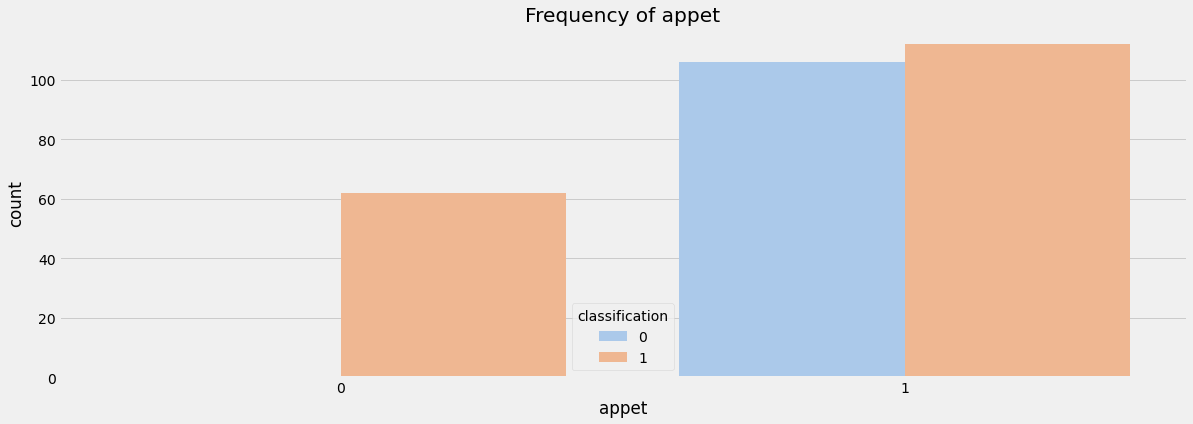

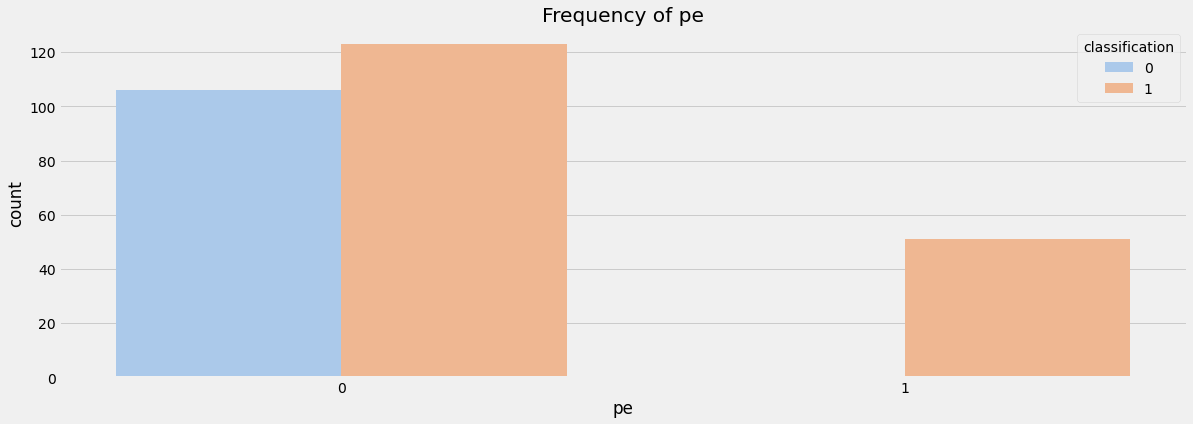

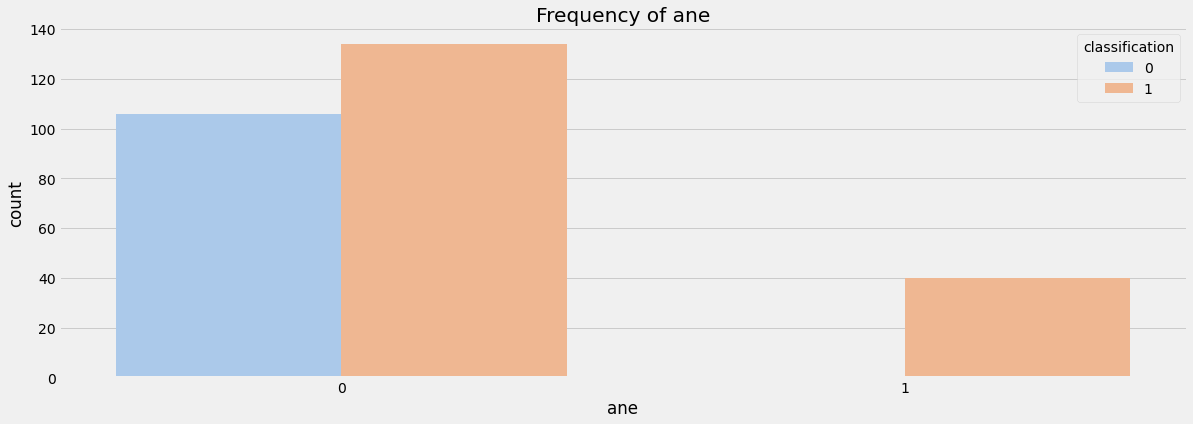

In [ ]:
# Histogram for categorical feature
#plt.rcParams.update({'font.size': 16})
for col in cat_col:
  ax = sns.countplot(x=col, hue='classification', palette='pastel',data=df)
  title = 'Frequency of '+str(col)
  plt.title(title)
  plt.show()

- We can see that there are some specific charateristics of classification as non Chronic Kidney Disease for each feature.

In [ ]:
# Count the frequency of classification
df['classification'].value_counts(normalize = True)

1    0.621429
0    0.378571
Name: classification, dtype: float64

- We can observe that around 37.8% of this dataset is classified as no Chronic Kidney Disease, and approximately 62.1% is classified as Chronic Kidney Disease in this dataset.


In [ ]:
# Remove outliers which are outside three standard deviation.
df_c = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

- After remove the outliers, the datast consists 210 records and 25 attrubutes.

Text(0.5, 1.0, 'Correlation heatmap')

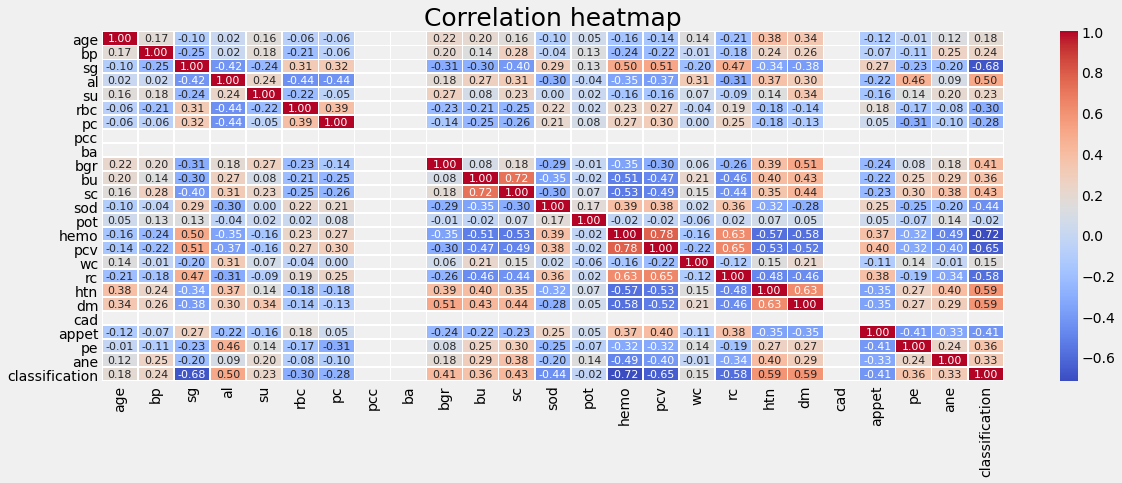

In [ ]:
# Check the correlation between features
corr = df_c.corr() 
f,ax = plt.subplots()
sns.heatmap(corr, annot = True, annot_kws={"size":11}, fmt= '.2f', 
            xticklabels= True, yticklabels= True,
            cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('Correlation heatmap', size=25)

###Apply Models
Principal Component Analysis and Logistic Regression

In [ ]:
# Split X and y 
y = df_c['classification']
X = df_c.drop(columns = ['classification'])

# Normalize by MinmaxScaler
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
# Fit the model
num_com, cv_mean = list(),list()
for i in range(1,len(X.columns)+1):
  steps = [('pca', PCA(n_components = i)), ('m', LogisticRegression())]
  model = Pipeline(steps = steps)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
  score = cross_val_score(model, X_norm, y, scoring='accuracy', cv=cv, n_jobs=-1)
  num_com.append(str(i))
  mean = score.mean()
  cv_mean.append(mean)
  print('Number of component: {} - cross valid mean score: {:.3f} and standard deviation: {:.3f}'.
        format(i,mean,score.std()))

Number of component: 1 - cross valid mean score: 0.921 and standard deviation: 0.058
Number of component: 2 - cross valid mean score: 0.937 and standard deviation: 0.055
Number of component: 3 - cross valid mean score: 0.940 and standard deviation: 0.048
Number of component: 4 - cross valid mean score: 0.940 and standard deviation: 0.044
Number of component: 5 - cross valid mean score: 0.943 and standard deviation: 0.047
Number of component: 6 - cross valid mean score: 0.943 and standard deviation: 0.043
Number of component: 7 - cross valid mean score: 0.960 and standard deviation: 0.035
Number of component: 8 - cross valid mean score: 0.962 and standard deviation: 0.038
Number of component: 9 - cross valid mean score: 0.960 and standard deviation: 0.039
Number of component: 10 - cross valid mean score: 0.959 and standard deviation: 0.040
Number of component: 11 - cross valid mean score: 0.959 and standard deviation: 0.034
Number of component: 12 - cross valid mean score: 0.959 and sta

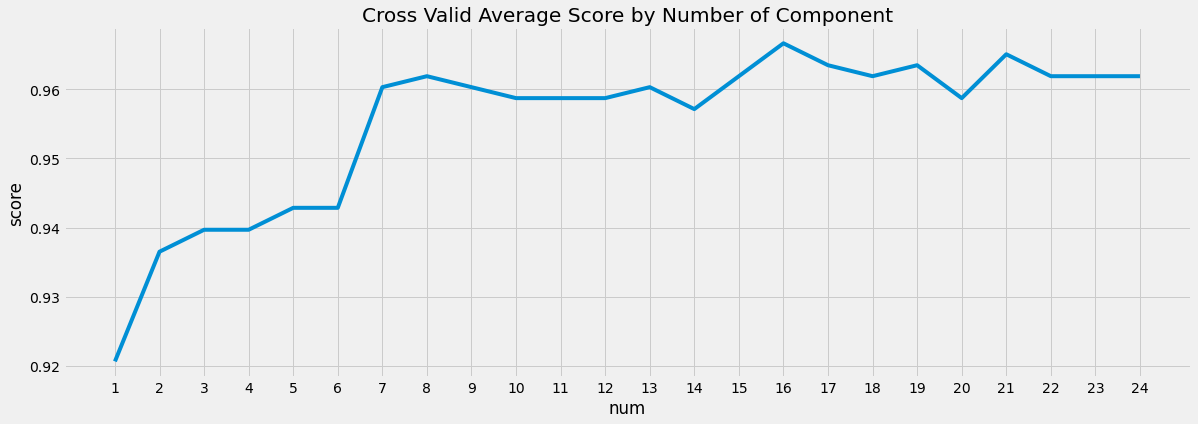

In [ ]:
# Create scorea dataframe
d = {'num': num_com, 'score': cv_mean}
score_df = pd.DataFrame(d)

# Create lineplot
sns.lineplot(x='num', y='score', data=score_df)
plt.title('Cross Valid Average Score by Number of Component')
plt.show()

In [ ]:
# Print the number of component with highest cv score
print('{} of component will get average cv score of {}'.
      format(score_df.iloc[score_df['score'].idxmax()][0],
             score_df.iloc[score_df['score'].idxmax()][1]))

16 of component will get average cv score of 0.9666666666666667


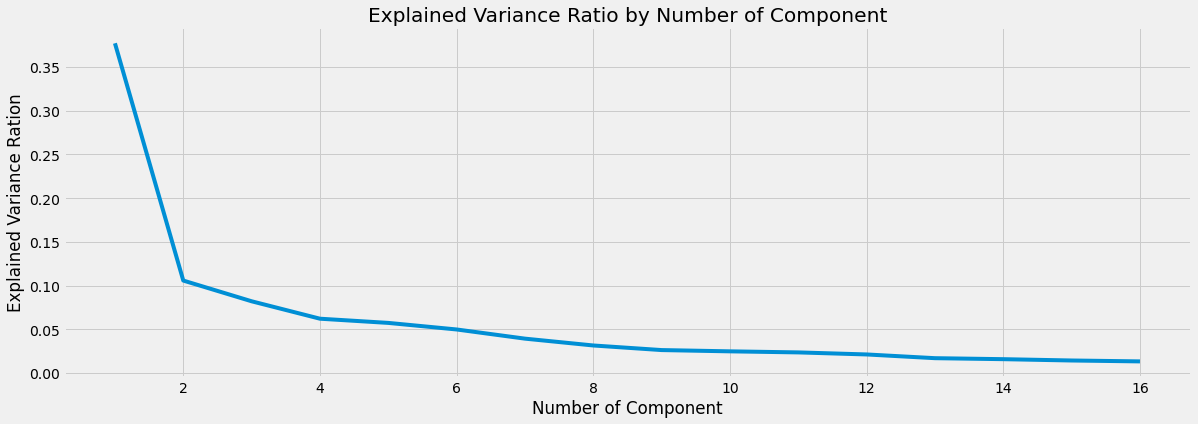

In [ ]:
# Perfomance:
pca = PCA(n_components=16)
pca.fit(X_norm)
evr = pca.explained_variance_ratio_

# Plot the explained variance ration
num = [i for i in range(1,17)]
d = {'num': num, 'evr': evr}
evr_df = pd.DataFrame(d)

# Create lineplot
sns.lineplot(x='num', y='evr', data=evr_df)
plt.title('Explained Variance Ratio by Number of Component')
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ration')
plt.show()

- We can see from the line plot above, the Principal Component 1(PC1) explaine at least 0.35 of variance of this dataset, which is the largest proportion among PCs.

In [ ]:
# Performance:
log = LogisticRegression()
model = log.fit(X_norm,y)
y_pred = model.predict(X_norm)
cr = classification_report(y,y_pred)
print('Performance:\n')
print('Overall Accuracy: ',accuracy_score(y,y_pred))
print('Explained Variance Ratio: ',sum(evr))
print('\nClassification Report:')
print(cr)

Performance:

Overall Accuracy:  0.9761904761904762
Explained Variance Ratio:  0.9608237616425689

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       106
           1       1.00      0.95      0.98       104

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



Takeaway:
>- The original dataset has 280 individuals with 26 attributes to records their health indicator, which allows us to analyze the characteristics of diagnosed as Chronic Kidney Disease.

>- While exploratory data, we clean the missing values(NaN), garbage data('\t'), and outliers(out of three std range), then normalize data by MinMaxScaler before we apply the model.

>- Since there are too many features(24) that will affect the time and performance of the model, we use PCA to reduce dimensionality. By pipeline(PCA and LogisticRegression), we find out that 16 principle components will get the highest cross-valid average score. 

>- We evaluate the model with 16 principal components, which explained 96.1% of the variance of this dataset with 0.976 overall accuracy. At the same time, the f1 score for two groups(Chronic Kidney Disease and non Chronic Kidney Disease) are both 0.98.